# Importing the liabraries

In [20]:
# Importing the liabraries
import tensorflow as tf
import pandas as pd
import cv2
import warnings
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D,  MaxPool2D, Flatten, Dropout, BatchNormalization, Input,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score,f1_score,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Loading and Analysis of Data

In [21]:
df= pd.read_csv('skin_lesions.csv')
df

,image_id,cell_type,is_benign,localization
0,ISIC_0025030,Benign keratosis-like lesions,1.0,scalp
1,ISIC_0025661,Benign keratosis-like lesions,1.0,scalp
2,ISIC_0027850,Benign keratosis-like lesions,1.0,ear
3,ISIC_0025837,Benign keratosis-like lesions,1.0,back
4,ISIC_0025209,Benign keratosis-like lesions,1.0,back
...,...,...,...,...
5365,ISIC_0030965,Melanocytic nevi,1.0,NaN
5366,ISIC_0028490,Benign keratosis-like lesions,1.0,NaN
5367,ISIC_0026722,Melanoma,1.0,NaN
5368,ISIC_0029038,Melanocytic nevi,1.0,NaN


In [3]:
# check for the missing values in the csv

df.isna().sum()

image_id          0
cell_type       100
is_benign       100
localization     13
dtype: int64

In [4]:
# drop the rows with missing values

df = df.dropna()

In [5]:
# again check for missing values

df.isna().sum()

image_id        0
cell_type       0
is_benign       0
localization    0
dtype: int64

Melanocytic nevi                  3528
Benign keratosis-like lesions      580
Melanoma                           576
Basal cell carcinoma               268
Actinic keratoses                  169
Vascular lesions                    74
Dermatofibroma                      62
Name: cell_type, dtype: int64


<AxesSubplot:>

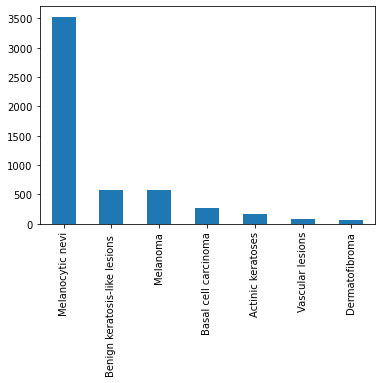

In [6]:
#check the class distribution
print(df['cell_type'].value_counts())
df['cell_type'].value_counts().plot.bar()

#### Observations
- The dataset is imbalanced. 

In [7]:
le = LabelEncoder()
df['cell_type'] = le.fit_transform(df['cell_type'])

In [8]:
# There is no missing values
# now lets load the images

all_data=[]
labels=[]
for i in tqdm (range(len(df))):
    path="/Users/priyank_7/Documents/Jupiter/Skinlesions/skin_lesions_images/"+df["image_id"][i]+".jpg"
    #print(path)
    img=cv2.imread(path)
    img=cv2.resize(img,(150,150))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img*(1/255)
    all_data.append(img)
    labels.append(df['cell_type'][i])

100%|██████████████████████████████████████| 5257/5257 [00:26<00:00, 201.77it/s]


In [9]:
all_data=np.array(all_data)
labels=np.array(labels)

In [10]:
# Balancing the data using SMOTE Over sampling method
# (Synthetic Minority Over Sampling Technique)

sm = SMOTE()
all_data = all_data.reshape(all_data.shape[0],-1)
all_data, labels = sm.fit_resample(all_data, labels)
all_data =all_data.reshape(all_data.shape[0],150,150,3)

In [11]:
print("Max pixel value = ",all_data.max())

# one hot encoding for class label
labels = to_categorical(labels)

print("Shape of images = ",all_data.shape)
print("Shape of labels = ",labels.shape)

Max pixel value =  1.0
Shape of images =  (24696, 150, 150, 3)
Shape of labels =  (24696, 7)


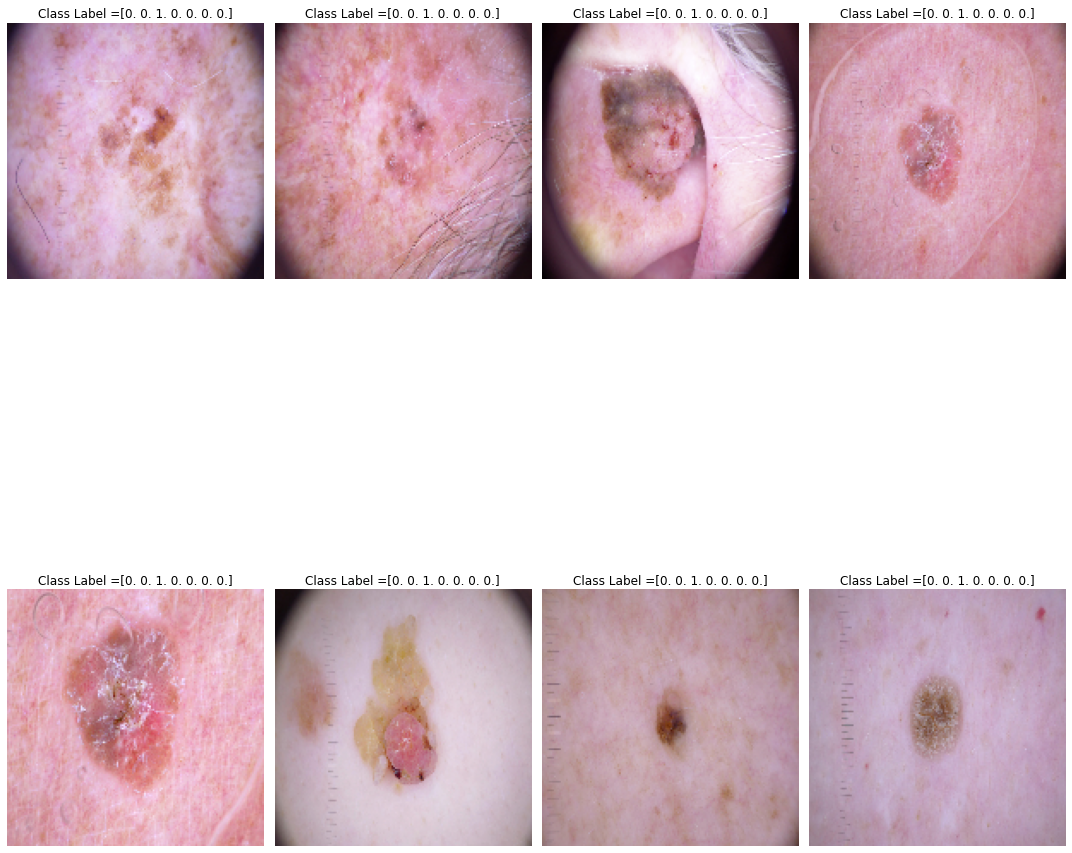

In [12]:
# plot Training images

def plot_images(images_arr,labels):
    fig, axes=plt.subplots(2, 4, figsize=(15,20))
    axes= axes.flatten()
    i=0
    for img , ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        title="Class Label ="+str(labels[i])
        ax.set_title(title)
        i+=1
    plt.tight_layout()
    plt.show()
        
plot_images(all_data[:10],labels[:10])

In [13]:
# Train and valid split
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.3, random_state=42)

del(all_data)
del(labels)

print("Shape of training images = ",X_train.shape)
print("Shape of training labels = ",y_train.shape)
print("Shape of validation images = ",X_test.shape)
print("Shape of validation labels  = ",y_test.shape)

Shape of training images =  (17287, 150, 150, 3)
Shape of training labels =  (17287, 7)
Shape of validation images =  (7409, 150, 150, 3)
Shape of validation labels  =  (7409, 7)


In [14]:
# plot accuracy, loss curve (graph)
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
accuracy_loss_plot = PlotLearning()

# Model

In [15]:
# initializing the model

input_shape = (150, 150, 3)
num_classes = 7

# creating sequential model
model = Sequential()

# adding extra conv2D, pooling layer(s)
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                      

2022-04-24 19:31:07.529836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 19:31:07.530228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

#### Define callbacks

In [17]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True),accuracy_loss_plot,learning_rate_reduction]

### Training the model

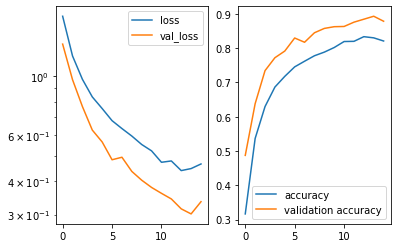

135/135 [==============================] - 57s 421ms/step - loss: 0.4659 - accuracy: 0.8206 - val_loss: 0.3355 - val_accuracy: 0.8783 - lr: 0.0010


In [18]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1    # Randomly zoom image 
)

# Fit the model
epochs = 15
batch_size = 128
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data=(X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=callbacks ,shuffle = True) 



# Performance Evaluation

2022-04-24 19:54:32.347804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test data 0.8782561749223917
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1044
           1       0.92      0.95      0.93      1060
           2       0.79      0.82      0.80      1067
           3       0.98      0.99      0.99      1040
           4       0.92      0.57      0.70      1071
           5       0.69      0.87      0.77      1077
           6       0.98      1.00      0.99      1050

    accuracy                           0.88      7409
   macro avg       0.89      0.88      0.88      7409
weighted avg       0.89      0.88      0.88      7409



<Figure size 1080x720 with 0 Axes>

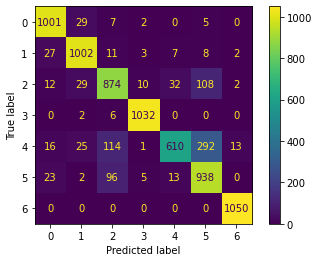

In [19]:
from sklearn.metrics import classification_report
# Get predictions on test data
y_predict=model.predict(X_test)
y_predict = np.argmax(y_predict, axis=-1)
y_true= np.argmax(y_test, axis=-1)

# plot confusion matrix
cm=confusion_matrix(y_true,y_predict)
plt.figure(figsize=(15,10))
ConfusionMatrixDisplay(cm).plot()

# check performance
print("Accuracy on test data",accuracy_score(y_true,y_predict))
print(classification_report(y_true,y_predict))